### Mathcups for points:

| DMS Coordinates       | Decimal Degrees   |
| --------------------- | ----------------- |
| 40°47'59"N, 0°43'12"E | 40.7997°, 0.7200° |
| 40°48'34"N, 0°44'23"E | 40.8094°, 0.7397° |
| 40°49'11"N, 0°45'34"E | 40.8197°, 0.7594° |
| 40°50'23"N, 0°46'47"E | 40.8397°, 0.7797° |
| 40°50'59"N, 0°47'59"E | 40.8497°, 0.7997° |
| 40°52'11"N, 0°49'11"E | 40.8697°, 0.8197° |


In [111]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import re
import copernicusmarine as cm
import pickle

from matplotlib import pyplot as plt
from pathlib import Path
from difflib import get_close_matches
from tqdm import tqdm

LAT, LON, TIME = 'lat', 'lon', 'time'

# Thresholds for mathcup
TIME_TH = pd.Timedelta(days=1)
LAT_TH = 0.1
LON_TH = 0.1

# Matchup region extension (window)
TIME_WINDOW = pd.Timedelta(days=1)
LAT_WINDOW = 0.06
LON_WINDOW = 0.06

p_pro = Path('../../../data/processed/rosa_marga_matchups/')
p_pro.mkdir(parents=True, exist_ok=True)

copernicus_product_id = 'cmems_obs-oc_med_bgc-reflectance_nrt_l3-olci-300m_P1D'   # It's OLCI product with 300m resolution

In [112]:
# Data preparation
ids = ['A', 'B', 'C', 'D', 'E', 'F']
lats = [40.7997, 40.8094, 40.8197, 40.8397, 40.8497, 40.8697]
lons = [0.7200, 0.7397, 0.7594, 0.7797, 0.7997, 0.8197]
times = [np.datetime64(datetime.datetime(2025, 4, 25))] * 6


### Open copernicus product

In [34]:
rrs = cm.open_dataset(dataset_id = copernicus_product_id)

INFO - 2025-05-19T14:32:20Z - Selected dataset version: "202207"
INFO - 2025-05-19T14:32:20Z - Selected dataset part: "default"


In [35]:
rrs = rrs.rename({'latitude': LAT, 'longitude': LON}).sortby(LAT).sortby(LON)

In [36]:
def match_up(ids, lats, lons, times, region, lat_win=LAT_WINDOW, lon_win=LON_WINDOW, time_win=TIME_WINDOW):
    match_ups = []

    for id_, lat, lon, date in tqdm(zip(ids, lats, lons, times), total=len(ids)):
        near_point = region.sel({TIME: date, LAT: lat, LON: lon}, method='nearest')

        near_date, near_lat, near_lon = near_point[TIME].values, near_point[LAT].values, near_point[LON].values
        if abs(near_date - date) < TIME_TH and abs(near_lon - lon) < LON_TH and abs(near_lat - lat) < LAT_TH:
            match = region.sel({TIME: slice(near_date - time_win, near_date + time_win),
                                    LAT: slice(near_lat - lat_win, near_lat + lat_win),
                                    LON: slice(near_lon - lon_win, near_lon + lon_win)})
            # if len(match_ups) != 0 and (
            #        len(regions[0][LAT].values[0]) != len(region[LAT].values) or len(regions[0][LON].values[0]) != len(
            #        region[LON].values)):
            #     continue
            lats_coord = xr.DataArray([match[LAT].values], dims=['Id', LAT])
            lons_coord = xr.DataArray([match[LON].values], dims=['Id', LON])
            time_coord = xr.DataArray([match[TIME].values], dims=['Id', TIME])
            if 'depth' in list(match.coords):
                match = match.sel(depth=region.depth.min())
            match = match.assign_coords({LON: lons_coord, LAT: lats_coord, TIME: time_coord, 'Id': ('Id', [id_])})
            match_ups.append(match)
    return match_ups


In [37]:
match_ups = match_up(ids, lats, lons, times, rrs)


 ... (more hidden) ...


In [38]:
matchups_ds = xr.concat(match_ups,  dim='Id')

In [39]:
matchups_ds.to_netcdf(p_pro / 'matchups.nc')

In [113]:
ds = xr.load_dataset(p_pro / 'matchups.nc')

In [45]:
# Select data with enough values (discard when majority is nan)

def dimension_len(ds, dim_name):
    if dim_name not in ds.sizes.keys():
        return 1
    return ds.sizes[dim_name]


def select_valid_data(ds, threshold=0.2):
    cube_dimension = (dimension_len(ds, 'lat') * dimension_len(ds, 'lon') *
                      dimension_len(ds, 'time'))
    values_count = (~ds.isnull()).sum(dim=('lat', 'lon'))
    if 'time' in ds.dims:
        values_count = (~ds.isnull()).sum(dim=('time', 'lat', 'lon'))
    no_null_percent = values_count / cube_dimension
    valid_indices = (no_null_percent > threshold).to_array().prod(axis=0) != 0
    return ds.isel(Id=valid_indices)

In [102]:
ds_time = ds.mean(dim='time')
# ds_time = ds.isel(time=1)

In [103]:
ds_final = select_valid_data(ds_time, 0.1)

In [104]:
ds_final

<xarray.Dataset>
Dimensions:       (Id: 6, lat: 45, lon: 35)
Coordinates:
    lat           (Id, lat) float32 40.74 40.74 40.75 ... 40.92 40.93 40.93
    lon           (Id, lon) float32 0.6633 0.6668 0.6702 ... 0.8759 0.8793
  * Id            (Id) <U1 'A' 'B' 'C' 'D' 'E' 'F'
Data variables: (12/20)
    QI_RRS412_5   (Id, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    QI_RRS442_5   (Id, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    QI_RRS490     (Id, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    QI_RRS510     (Id, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    QI_RRS560     (Id, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    QI_RRS673_75  (Id, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ...            ...
    RRS673_75     (Id, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    RRS681_25     (Id, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    RRS708_75     (Id, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    RRS778_75     (Id, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    RRS865        (Id, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SENSORMASK    (Id, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

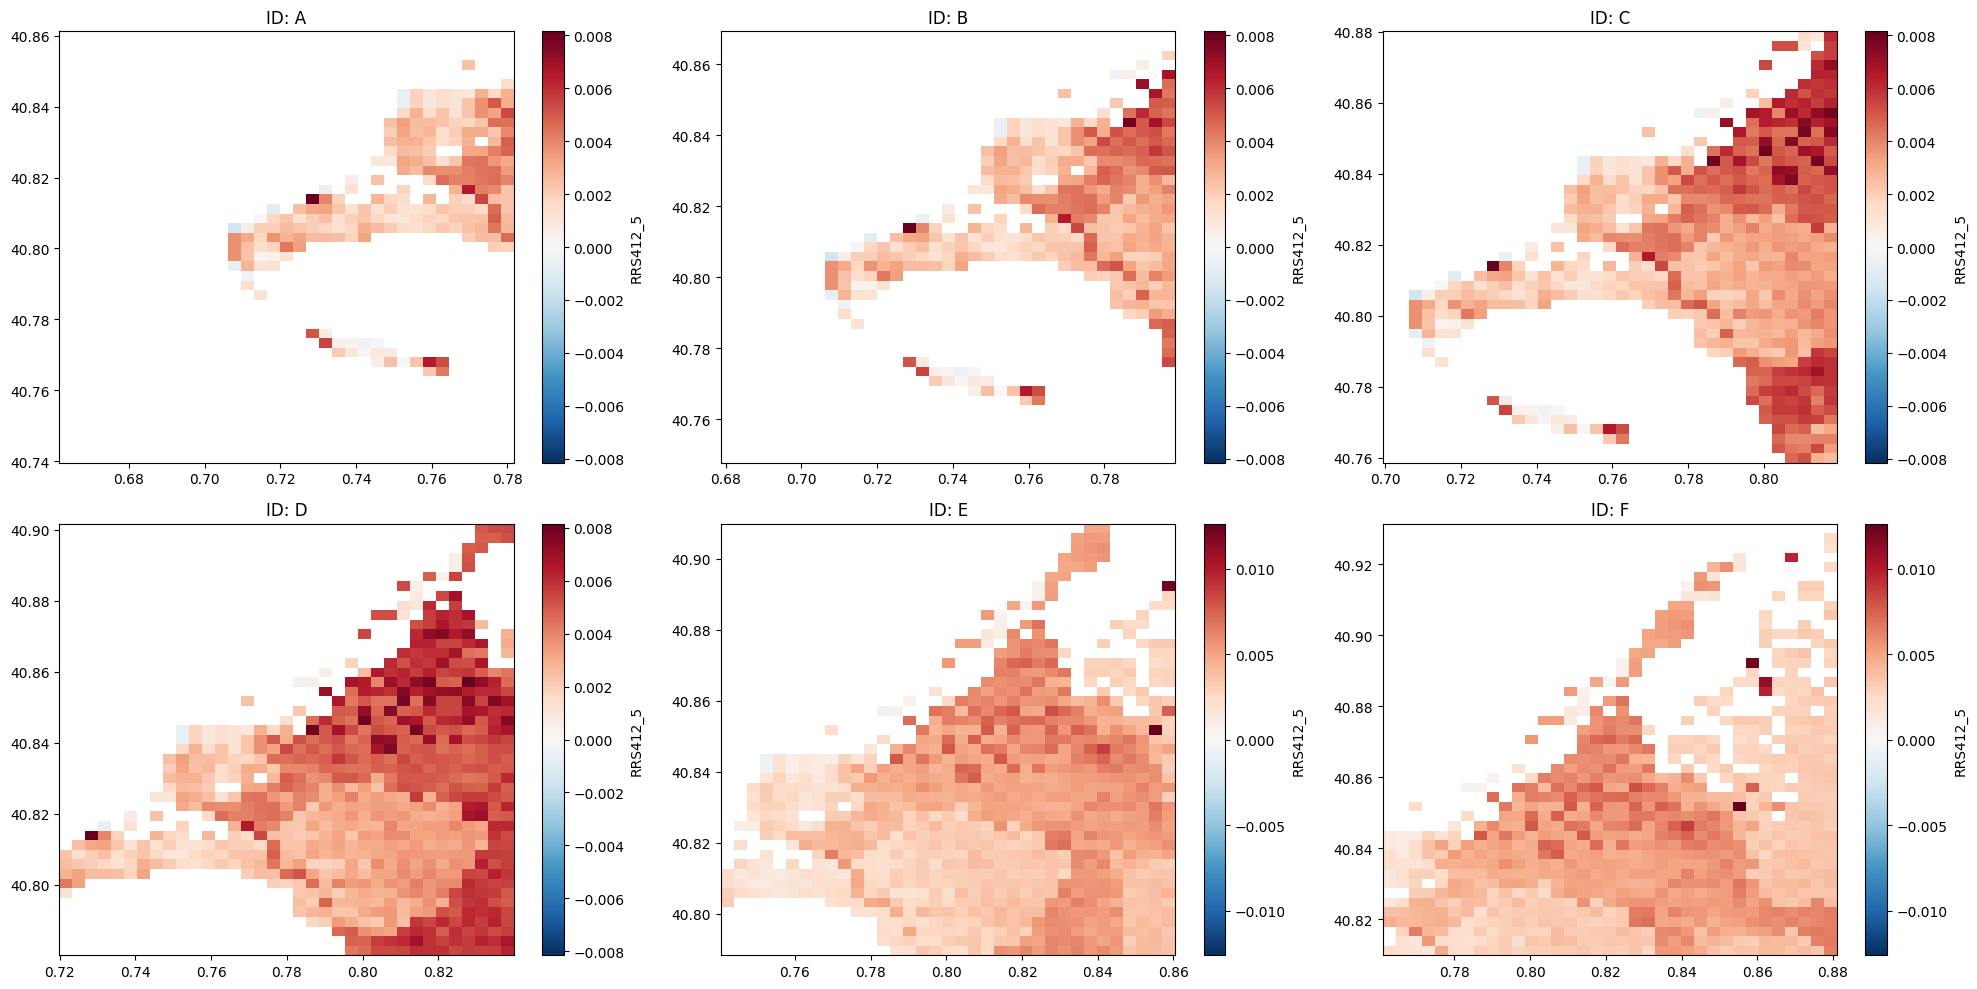

In [119]:

# Create a 2x3 grid of subplots without shared axes
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()  # Flatten in case it's a 2D array

# Loop through each ID and plot on the corresponding subplot
for idx, id_ in enumerate(['A', 'B', 'C', 'D', 'E', 'F']):
    ax = axes[idx]
    ds_final.sel(Id=id_)['RRS412_5'].plot(ax=ax)
    ax.set_title(f'ID: {id_}')
    ax.set_xlabel('')  # Remove if you want x-axis label
    ax.set_ylabel('')  # Remove if you want y-axis label

# Hide any unused subplots (if fewer than 6)
for ax in axes[len(['A', 'B', 'C', 'D', 'E', 'F']):]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig('wv_412.png')
plt.show()
